## Jenn Wong
email: jennwong@berkeley.edu


#### Importing packages to be used for analysis

In [3]:
import pandas as pd
from collections import Counter
import pickle
from fuzzywuzzy import fuzz

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

Reading the data into the notebook

#### Question 1
Identify pockets in San Francisco with a high concentration of active businesses. Please
provide visualization(s) to support your analysis.

Upon looking at the available information, I see that zipcode, and business location is a way for me to retrieve location information to answer the prompt. To find active businesses, the business should not have a end date. For sanity check, I should only look at the companies that have a start date just in case.

I will be defining 'pockets' as zipcodes in SF and 'active businesses' as businesses with a start date and NO end date

While I know that latitude, and longitudinal data is available. The question is asking for me to identify pockets. I will be interpretting this as zipcodes, because it's an intuitive way for me to group businesses together into a location. I see that I have some missing zipcodes, so I need to address that issue either by finding the correct zipcode, or leaving out the data

Note to self: SF County only has the city of SF LOL

##### This attempt will rely on the 'Source Zipcode' to define SF businsses
1. Get city = 'San Francisco'
2. Get zipcode for SF for sanity check

In [6]:
df = pd.read_csv('tunein_sf_business_dataset.csv', encoding = 'latin-1')
df.head()

,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,Business Start Date,Business End Date,...,NAICS Code,NAICS Code Description,Parking Tax,Transient Occupancy Tax,LIC Code,LIC Code Description,Supervisor District,Neighborhoods - Analysis Boundaries,Business Corridor,Business Location
0,0026883-11-001,26883,Chevron Texaco Corp,Chevron,2998 San Jose Av,San Francisco,CA,94112.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,11.0,Oceanview/Merced/Ingleside,NaN,"2998 SAN JOSE AV\rSan Francisco, CA 94112\r(37..."
1,0026883-12-001,26883,Chevron Texaco Corp,Chevron,301 Claremont Blvd,San Francisco,CA,94127.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,7.0,West of Twin Peaks,NaN,"301 CLAREMONT BLVD\rSan Francisco, CA 94127\r(..."
2,0026883-13-001,26883,Chevron Texaco Corp,Chevron,3675 Geary Blvd,San Francisco,CA,94118.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,1.0,Lone Mountain/USF,NaN,"3675 GEARY BLVD\rSan Francisco, CA 94118\r(37...."
3,0026883-15-001,26883,Chevron Texaco Corp,Chevron,2301 Lombard St,San Francisco,CA,94123.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,2.0,Marina,NaN,"2301 LOMBARD ST\rSan Francisco, CA 94123\r(37...."
4,0026883-16-001,26883,Chevron Texaco Corp,Chevron,1288 19th St,San Francisco,CA,94107.0,10/1/1968,NaN,...,NaN,NaN,False,False,NaN,NaN,10.0,Potrero Hill,NaN,"1288 19TH ST\rSan Francisco, CA 94107\r(37.761..."


In [4]:
ratio = 60 # chosen through iterative approach--decreasing from 90 to until got erroneous 'matches'

partial_matches = []

# i only care about cities similar to SF. instead of cleaning, i could use fuzzy wuzzy. 
# if i had more time, i would clean it better so that I make sure not to miss businesses
# i got the low hanging fruit to make analysis

for city in set(df[df['State'] == 'CA']['City'].values):
    if (fuzz.partial_ratio(city, 'San Francisco')) >= ratio:
        partial_matches.append(city)

# some mis-matches that I need to remove from the list        
remove_cities = set(['Tracy', 'Anticoh', 'Chico', 'Davis', 'Encino', 'S San Fran', 'S San Francisco',
                'S+san+francisco','S. San Francisco', 'S.+san+francisco', 'San', 'San Bruno', 'San Ramon',
                'San+ramin', 'San+ramon', 'Sanger'])

cities = sorted(set(partial_matches) - remove_cities)

# to get rid of south san francisco since it's part of san mateo county
cutoff_index = [c.lower().startswith('so') for c in cities].index(True)

cities = cities[:cutoff_index]

df['City'].replace(cities, 'San Francisco', inplace = True)

In [5]:
# this cell is for sanity check to make sure I got the low-hanging fruit

# import operator
# cities_counter = (Counter(df.City))
# sorted_x = sorted(cities_counter.items(), key=operator.itemgetter(1), reverse = True)
# sorted_x

In [6]:
#fcn to get zipcode from business location

def get_zipcode(string):
    """
    fcn takes a string, and parses the zipcode out to sanity check again the 'source zipcode' column
    """
    try:
        zipcode = (string.split('\r')[1].split(' ')[-1])
        if zipcode[0] == '9': # i know that zipcodes start with 9 in SF County
            return int(zipcode)
    except:
        return string# to get the last five numbers with the assumption that it's a 5-digit zipcode


In [7]:
# i want active = no end data but has start date
df['parsed_zip'] = df['Business Location'].apply(get_zipcode).fillna(0)

active_mask = (pd.isnull(df['Business End Date']) & (pd.isnull(df['Business Start Date']) == False)) #for sanity check
active = df[active_mask]
sf_active = active[active['City'] == 'San Francisco']

# print(f'number of active sf businesses: {len(sf_active)} \n')

In [8]:
# these zipcodes are stored as int but in the df zipcodes are strings. something to keep in mind

# source: https://www.zillow.com/browse/homes/ca/san-francisco-county/

sf_zipcodes = [94151,94159, 94158, 94102, 94104, 94103, 94105, 94108, 94177, 94107, 94110, 
          94109, 94112, 94111, 94115, 94114, 94117, 94116, 94118, 94121, 94123, 94122, 94124, 
          94127, 94126, 94129, 94131, 94133, 94132, 94134, 94139, 94143]

# len(sf_zip) #there are 32

In [9]:
#to fill in the missing source zipcode with the parsed zipcode

sf_active['parsed_zip'] = sf_active['Business Location'].astype(str).apply(get_zipcode).fillna(0)
sf_active['parsed_zip'].replace('nan', 0, inplace = True) # sometimes things slip through

sf_active['Source Zipcode'].fillna(sf_active['parsed_zip'], inplace = True) # if missing try the parsed zip
sf_active['Source Zipcode'] = sf_active['Source Zipcode'].astype(int)


known_sf_active = sf_active[sf_active['Source Zipcode'].isin(sf_zipcodes)] # i only care about these zip codes

# print(len(sf_active)- len(known_sf_active))


In [10]:


# i lost almost 2k rows :( if i had more time, i would do some more cleaning

# note to self: there are 2420 mislabeled zipcodes that are 'sf' but not of sf zipcode. if i had more time, I would 
# try to figure out why that is and how to fix it so that i could recover the missing info

# sum(~sf_active['Source Zipcode'].isin(sf_zip))
# len(not_sf_active)


# upon exploration i saw that a lot of the zipcodes were for S. SF and not SF

In [11]:
#saving my progress so i can just load it from the pickle file yay

# with open ('cleaned_sf_data.pkl', 'wb') as file:
#     pickle.dump(known_sf_active, file)
#     file.close()

In [12]:
sf_active_businesses = Counter(known_sf_active['Source Zipcode'])
sf_zip = pd.DataFrame()
sf_zip['zipcode'] = sf_active_businesses.keys()
sf_zip['zipcode'] = sf_zip['zipcode'].astype(str) # so that it will order by height
sf_zip['count'] = sf_active_businesses.values()
sf_zip.sort_values('count', ascending = False, inplace = True)


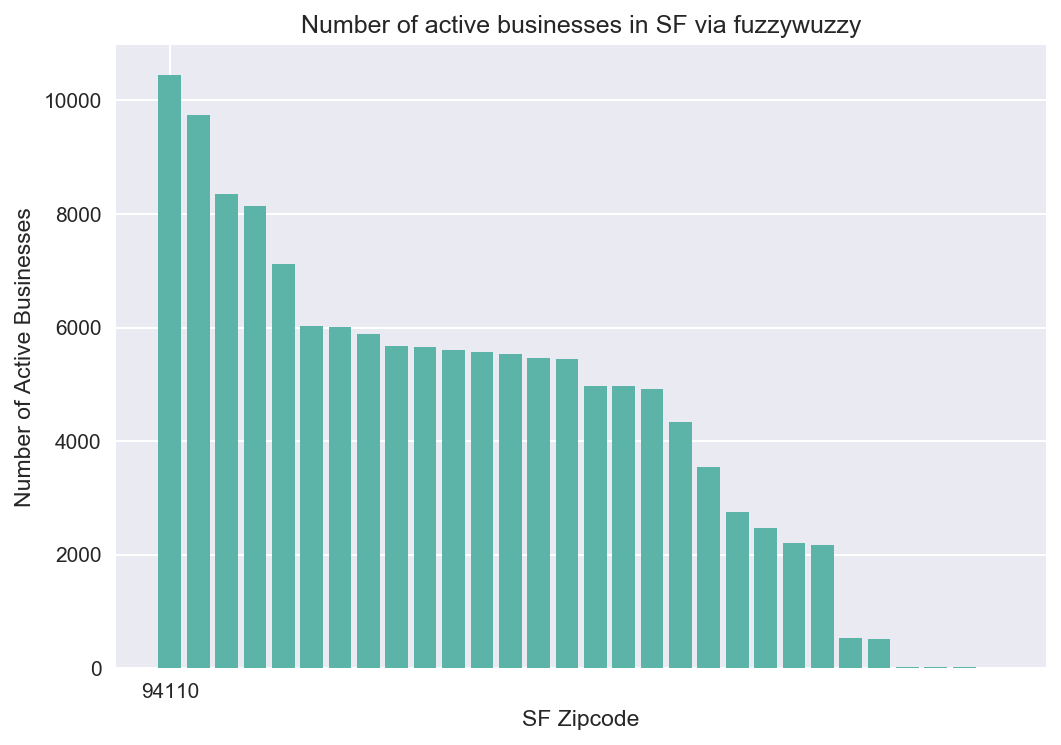

In [13]:
#creating a bar graph to show number of businesses in the zipcode
tune_in_color = '#5CB3A8'

plt.figure(dpi = 150)
plt.bar(sf_zip['zipcode'],sf_zip['count'], color = tune_in_color) #tried to match tunein colors haha

popular_zip = sf_zip['zipcode'].values[0] # because it's sorted! yay

plt.xticks(popular_zip)
plt.ylabel('Number of Active Businesses')
plt.xlabel('SF Zipcode')
plt.title('Number of active businesses in SF via fuzzywuzzy');

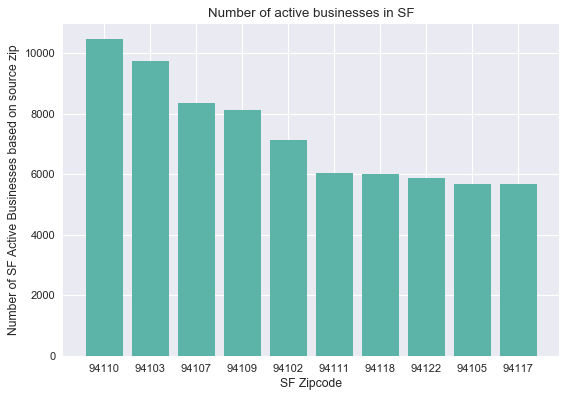

In [14]:
top_n = 10

plt.figure(dpi = 80)
plt.bar(sf_zip['zipcode'][:top_n],sf_zip['count'][:top_n], color = tune_in_color) #tried to match tunein colors haha

popular_zip_fuzzy = sf_zip['zipcode'].values[0:top_n] # because it's sorted! yay

plt.xticks(popular_zip_fuzzy)
plt.xlabel('SF Zipcode')
plt.ylabel('Number of SF Active Businesses based on source zip')
plt.title('Number of active businesses in SF');

##### This is a sanity check to see what results I would get if I solely relied on the zipcode from parsing Businsess Location

1. parse through businsses location and get zipcode
2. if zipcode is known to be sf, use that as the filter to get active sf locations

In [15]:
# this is a sanity check to compare with the fuzzwuzzy approach
# I solely rely on parsed business locaiton to retrieve the zipcode


zipcode_active = active[active.parsed_zip.isin(sf_zipcodes)]


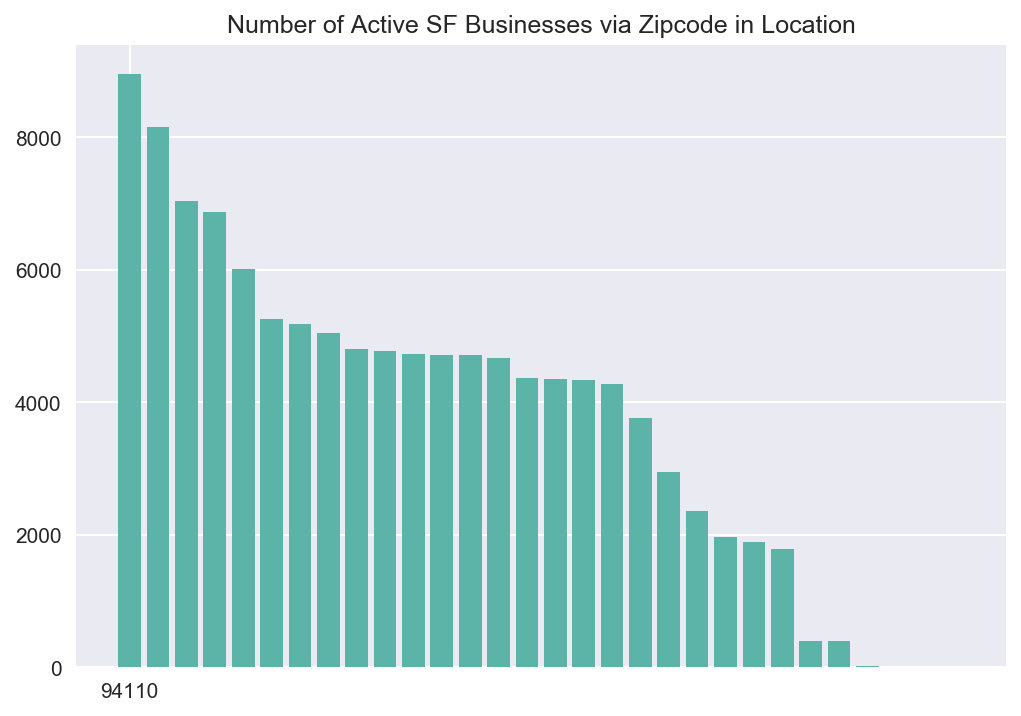

In [16]:
zipcode_counts = Counter(zipcode_active.parsed_zip)
zipcode_counts_df = pd.DataFrame()
zipcode_counts_df['zipcode'] = zipcode_counts.keys()
zipcode_counts_df['zipcode'] = zipcode_counts_df['zipcode'].astype(str)
zipcode_counts_df['counts'] = zipcode_counts.values()
zipcode_counts_df.sort_values('counts', inplace = True, ascending = False)

popular_zip = zipcode_counts_df['zipcode'].values[0]

# zipcode_counts_df.head()
plt.figure(dpi = 150)
plt.bar(zipcode_counts_df.zipcode, zipcode_counts_df.counts, color = tune_in_color)
plt.xticks(popular_zip);
plt.title('Number of Active SF Businesses via Zipcode in Location');

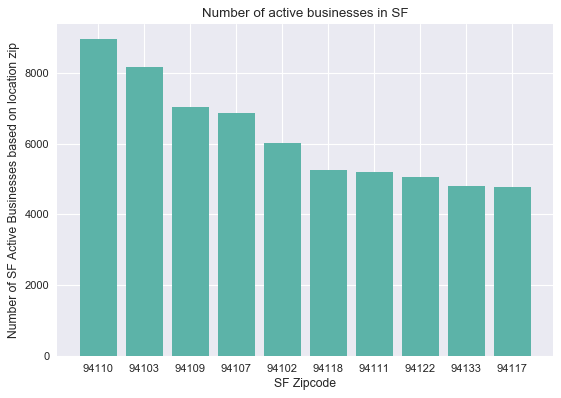

In [17]:
top_n = 10

plt.figure(dpi = 80)
plt.bar(zipcode_counts_df['zipcode'][:top_n],zipcode_counts_df['counts'][:top_n], color = tune_in_color) #tried to match tunein colors haha

popular_zip = zipcode_counts_df['zipcode'].values[0:top_n] # because it's sorted! yay

plt.xticks(popular_zip)
plt.xlabel('SF Zipcode')
plt.ylabel('Number of SF Active Businesses based on location zip')
plt.title('Number of active businesses in SF');

In [18]:
set(popular_zip).symmetric_difference(set(popular_zip_fuzzy)) # this is to show the different zipcodes returned

{'94105', '94133'}

Note that there is some discrepancy between using the source zipcode, and the parsed zipcode. If I had more time, I would try to figure out why that is.

#### Question 2

To promote growth in less popular industries in San Francisco, the county is offering a tax
break for *new* businesses in these categories to encourage them set up shop in San
Francisco. Identify the NAICS code and description of businesses that would benefit from
this scheme.

As per the prompt pdf in the google drive, I will be operating under the assumption that columns 'NAICS' et al have been cleaned, and I can use the resulting dataset to make my recommendations

In [19]:
smallest_n = 5

code_counter = Counter(known_sf_active['NAICS Code Description'].astype(str))
sf_code_df = pd.DataFrame(list(code_counter.items()), columns = ['Industry', 'Count'])
sf_code_df.sort_values('Count', inplace = True, ascending = True)

#i'm going to join another df to get the NAICS code

sf_code_sf = pd.merge(sf_code_df, known_sf_active[['NAICS Code Description', 'NAICS Code']].drop_duplicates(), how = 'left', 
                     left_on = 'Industry', right_on = 'NAICS Code Description').drop('NAICS Code Description', axis =1)

sf_code_sf.head(smallest_n)

,Industry,Count,NAICS Code
0,Utilities,100,2200-2299
1,Insurance,484,5240-5249
2,Certain Services,536,8100-8399
3,Certain Services,536,8110-8139
4,Manufacturing,1279,3100-3399


If I had more time, I would try a different definition in which I either incorperate chronicologically relevant suggestions and/or consider only businesses that are still open, because ones that closed logically doesnt provide market value and should probably not be encouraged with tax break

I would also try to get tax returns on businsses to evaluate viability

In [20]:
# this function for the graph aesthetics and does not provide functional value

def separate_string(s):
    num_words = len(s.split())
    if num_words > 2:
        words = s.split()
        half_number = num_words // 2
        return ' '.join(words[:half_number])+'\n'+' '.join(words[half_number:])
    return s

industry_names = [separate_string(industry) for industry in sf_code_df.Industry[:smallest_n]]

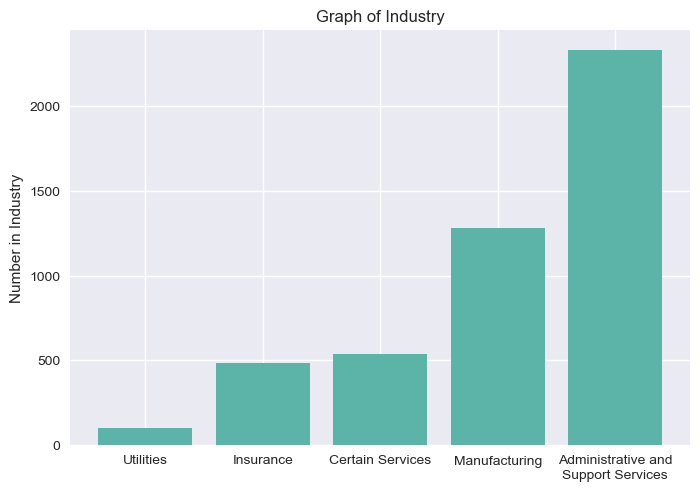

In [21]:
plt.figure(dpi = 100)
plt.bar(industry_names, sf_code_df.Count[:smallest_n], color = tune_in_color)
plt.title('Graph of Industry')
plt.ylabel('Number in Industry');

#### Question 3


What are the different industry types that have emerged in San Francisco over the years.
Are there any trends you can identify?

##### This is if you defined it as the number of businesses that opened in time frame

In [22]:
known_sf_active['Business Start Date'] = pd.to_datetime(known_sf_active['Business Start Date'])
known_sf_active['start_year'] = known_sf_active['Business Start Date'].dt.year
known_sf_active['start_decade'] = known_sf_active['start_year']//10 * 10

In [23]:
mask_2020 = known_sf_active['start_decade'] == 2020

known_sf_active.loc[mask_2020, 'start_decade'] = 1920 
# known_sf_active[mask_2020]['start_decade']# this is weird. Unless they're planning to open on that date, i'm going to put them into the 2010 decade because that is more reasonable
# some googling tells me that they are of the 1900 not 2000 century so i need to fix this


# if i had more time, i would go through and make sure that all the years are correct because if this is the case
# there is def more businesses with the wrong start dates

In [24]:
industry_trends = known_sf_active.groupby(['start_decade', 'NAICS Code Description']).size().reset_index()
industry_trends.rename(columns= {0: 'num_opened'}, inplace = True)

# sanity check
# sum(industry_trends.num_opened.values), len(known_sf_active[~known_sf_active['NAICS Code Description'].isnull()])

In [25]:
# find top performing industries in 2010 decade
# note that colors for the lines are cycled, so it because hard to distinguish between lines
n_2010 = 6 #use this to get the top trending industries of 2010 decade


top_2010 = industry_trends.start_decade == 2010
top_2010_industries = industry_trends[top_2010].sort_values('num_opened', ascending = False)['NAICS Code Description'].values[:n_2010]

if I wanted to see all of the data from the dataset
```python
plt.figure(dpi=80)

for name, grp in (industry_trends.groupby(['NAICS Code Description'])):
    plt.plot(grp['start_decade'], grp['num_opened'], '-', label=name)

plt.ylabel('num opened')
plt.xticks(grp['start_decade'].drop_duplicates())
plt.title('SF Industry Trends')
plt.legend();
```

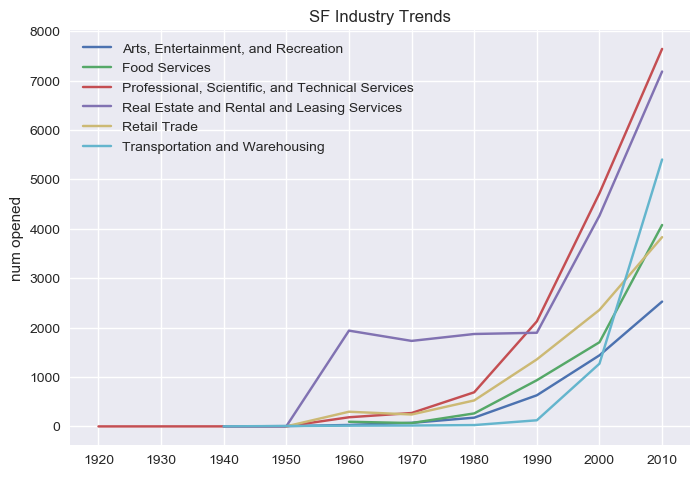

In [27]:
plt.figure(dpi=100)

for name, grp in (industry_trends.groupby(['NAICS Code Description'])):
    if name in top_2010_industries:
        plt.plot(grp['start_decade'], grp['num_opened'], '-', label=name)

plt.ylabel('num opened')
plt.xticks(range(1920, 2020, 10))
plt.title('SF Industry Trends')
plt.legend();

##### This is if you defined emerging as greatest percent increase in time frame

In [28]:
decade_2000_mask = industry_trends.start_decade == 2000
decade_2010_mask = industry_trends.start_decade == 2010

industry_trends_again = industry_trends[decade_2000_mask]
industry_trends_again['num_opened_2010'] = industry_trends[decade_2010_mask]['num_opened'].values
industry_trends_again['percent_increase'] = (industry_trends_again['num_opened_2010'] - industry_trends_again['num_opened'])/industry_trends_again['num_opened'] * 100
industry_trends_again.sort_values('percent_increase', ascending = False, inplace = True)


top_n = 6
industry_trends_again.iloc[:top_n,:].drop('start_decade', axis = 1)

,NAICS Code Description,num_opened,num_opened_2010,percent_increase
90,Accommodations,394,2475,528.172589
104,Transportation and Warehousing,1271,5405,325.255704
93,Certain Services,113,366,223.893805
105,Utilities,19,53,178.947368
97,Information,593,1595,168.971332
96,Food Services,1705,4079,139.237537


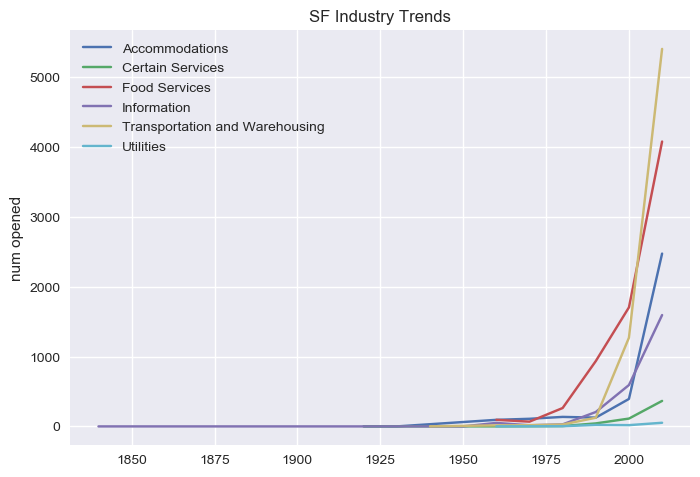

In [29]:
# if i wanted to graph the industries that i found from this definition

top_n = 6
industry_trends_again.sort_values('percent_increase', ascending = False, inplace = True)
top_percentage = industry_trends_again['NAICS Code Description'].values[:top_n]

plt.figure(dpi=100)

for name, grp in (industry_trends.groupby(['NAICS Code Description'])):
    if name in top_percentage:
        plt.plot(grp['start_decade'], grp['num_opened'], '-', label=name)

plt.ylabel('num opened')
# plt.xticks(range(1920, 2020, 10))
plt.title('SF Industry Trends')
plt.legend();

#### Question 4
If you had more time, what other conclusions might you be able to draw from this data?
What interesting stories might you be able to tell?

1. If I had more time, I would increase the resolution of the analysis and look at blocks/neighborhoods within the zip code to see if I can increase the specificity.
2. If I had more time, I would also be more thorough in cleaning. At the moment, I’ve gotten all the low-hanging fruit.
3. I would like to take the coordinates of the businesses locations and get the zip code to ensure that the zip codes are correct and to account for businesses without zip codes listed
4. If I had more time, I would try to clean the NAICS code better, because there are 45k missing descriptions
5. If I had more time, I would make sure that business start dates and end dates are accurate, because upon initial inspection, there were some mistakes


If I had more time, I would also like to see how different industry trends happened over time but with more refinement (looking at neighborhoods/zipcodes) to see if there were changes in the neighborhoods in terms of what industries were popular.

I would also like to dig deeper, and try to figure out why these trends happened the way they did. What external or internal motivations caused these observations?